In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
base_dir = '/content/drive/MyDrive/UAS PMDPM 2024/DATASET'

img_size = 180
batch = 32
validation_split = 0.1

dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="training",
    interpolation="bilinear"
)

class_names = ['Beras Hitam', 'Beras Merah', 'Beras Putih']
print("Class Names:", class_names)


Found 269 files belonging to 3 classes.
Using 243 files for training.
Class Names: ['Beras Hitam', 'Beras Merah', 'Beras Putih']


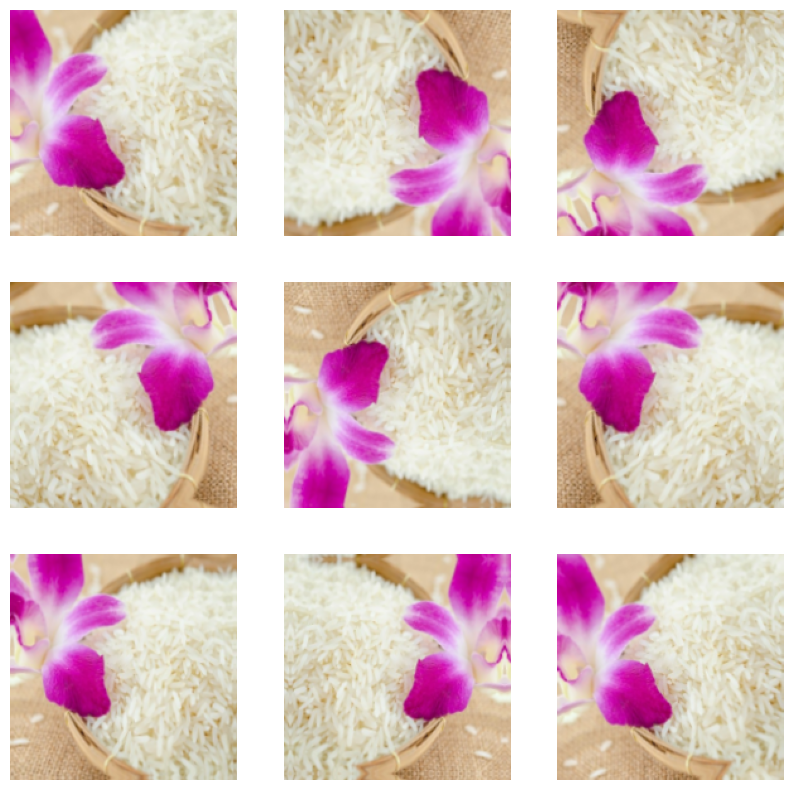

In [8]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')



In [9]:
base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


<ipython-input-9-b70865b08e16>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 944ms/step - accuracy: 0.4542 - loss: 1.3815
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.4805 - loss: 1.2338
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - accuracy: 0.5436 - loss: 0.9984
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 789ms/step - accuracy: 0.6291 - loss: 0.8083
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - accuracy: 0.7278 - loss: 0.7364
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 805ms/step - accuracy: 0.7564 - loss: 0.5986
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.7983 - loss: 0.5198
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step - accuracy: 0.8442 - loss: 0.3932
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step - accuracy: 0.8465 - loss: 0.4591
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 753ms/step - accuracy: 0.8701 - loss: 0.3608
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.8735 - loss: 0.3172
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 811ms/step - accuracy: 0.8877 - l

In [10]:
model.save('/content/drive/MyDrive/DATASET/model_mobilenet.h5')

In [12]:
def classify_images(image_path, model, class_names):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    class_idx = np.argmax(result)
    confidence = np.max(result) * 100

    print(f"Prediction: {class_names[class_idx]}")
    print(f"Confidence: {confidence:.2f}%")

    input_image = Image.open(image_path)
    input_image.save('/content/drive/MyDrive/UAS PMDPM 2024/Test/Hitam/images (39).jpg')

    return f"Prediction: {class_names[class_idx]} with {confidence:.2f}% confidence. Image saved."

image_path = '/content/drive/MyDrive/UAS PMDPM 2024/Test/Hitam/images (42).jpg'
result = classify_images(image_path, model, class_names)
print(result)

image_path = '/content/drive/MyDrive/UAS PMDPM 2024/Test/Merah/Image_86.jpg'
result = classify_images(image_path, model, class_names)
print(result)

image_path = '/content/drive/MyDrive/UAS PMDPM 2024/Test/Putih/images (32).jpg'
result = classify_images(image_path, model, class_names)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Beras Hitam
Confidence: 51.86%
Prediction: Beras Hitam with 51.86% confidence. Image saved.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: Beras Merah
Confidence: 50.90%
Prediction: Beras Merah with 50.90% confidence. Image saved.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Beras Putih
Confidence: 56.28%
Prediction: Beras Putih with 56.28% confidence. Image saved.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


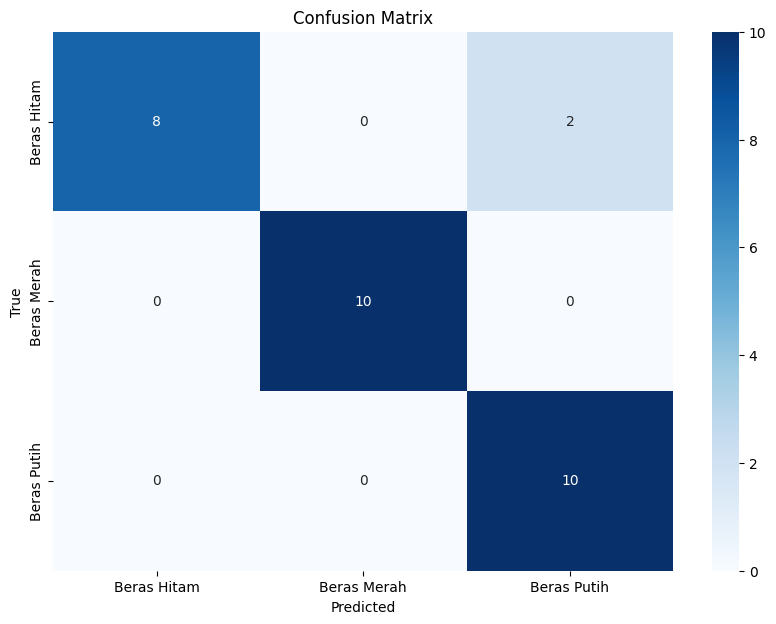

Accuracy: 0.93
Precision: [1.         1.         0.83333333]
Recall: [0.8 1.  1. ]
F1 Score: [0.88888889 1.         0.90909091]


In [18]:
import seaborn as sns
test_dir = '/content/drive/MyDrive/UAS PMDPM 2024/Test'
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=False
)

y_pred = model.predict(test_data)
y_pred_class = np.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy.numpy():.2f}")
print(f"Precision: {precision.numpy()}")
print(f"Recall: {recall.numpy()}")
print(f"F1 Score: {f1_score.numpy()}")
